In [1]:
# import packages
from gru import dataset, example_printer
from gru.gru_v2 import EncoderNet, DecoderNet, EncoderDecoder
from gru.cce import CCE
import torch
import wandb
import pandas as pd
from selfies_tools import SELFIESVectorizer, determine_alphabet
import random
import selfies as sf

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
x_path = './GRU_data/combined_klek.parquet'
y_path = './GRU_data/combined_selfies.parquet'

In [4]:
# weights and biases
!wandb login

wandb: Currently logged in as: hubertrybka1 (mldd23). Use `wandb login --relogin` to force relogin


# Data prep

In [5]:
alphabet = determine_alphabet(y_path) 
vectorizer = SELFIESVectorizer(alphabet, pad_to_len = 128)

In [6]:
dataset = dataset.GRUDataset(x_path, y_path, vectorizer)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print("Dataset size:", len(dataset))
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Dataset size: 402863
Train size: 362576
Test size: 40287


In [7]:
from torch.utils.data import DataLoader
batch_size = 512
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

# NN architecture

In [8]:
# Set hyperparameters
encoding_size = 256
hidden_size = 256
num_layers = 1
learn_rate = 0.00025
dropout = 0 # dropout must be equal 0 if num_layers = 1

# Init model
model = EncoderDecoder(
    fp_size=4860,
    encoding_size=encoding_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout).to(device)

# Training loop

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(model, train_loader, test_loader, vectorizer, device):

    EPOCHS = 20

    # Define dataframe for training progess display
    epochs_range = range(1,EPOCHS+1)
    metrics = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss']);
    metrics['epoch'] = epochs_range
    
    # Init example printer
    printer = example_printer.ExamplePrinter(test_loader, num_examples=5)

    # Define pyplot for plotting metrics
    fig, ax = plt.subplots(ncols=2, figsize=(7, 3), layout="constrained")
    dh = display(fig, display_id=True)

    # Define loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    criterion = CCE()

    # wandb config and init
    config = dict()
    config['learning rate'] = learn_rate
    config['encoding size'] = model.encoding_size
    config['criterion'] = criterion
    config['optimizer'] = optimizer
    config['num epochs'] = EPOCHS
    config['Trainable parameters'] = sum(p.numel() for p in model.parameters() if p.requires_grad)
    config['hidden size'] = model.hidden_size
    config['Number of layers'] = num_layers
    config['Dropout'] = model.decoder.dropout
    config['Batch size'] = batch_size
    wandb.init(project="encoded-token-concat", config=config)

    print("Starting Training of GRU")
    print(f"Device: {device}")
    
    samples = []
    
    # Start training loop
    for epoch in epochs_range:
        print(f'Epoch: {epoch}')
        epoch_loss = 0
        model.train()
        #for batch_idx, (X,y) in enumerate(tqdm(train_loader)):
        X, y = next(iter(train_loader))
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(X, y, teacher_forcing=True).to(device)
        loss = criterion(y, output)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # calculate loss and log to wandb
        avg_loss = epoch_loss / len(train_loader)
        val_loss = evaluate(model, test_loader)
        metrics_dict = {'epoch': epoch,
                        'train_loss': avg_loss,
                        'val_loss': val_loss}
        wandb.log(metrics_dict)

        # Update metrics df
        metrics.loc[len(metrics)] = metrics_dict

        # Display metrics
        ax[0].clear()
        ax[0].plot(metrics.epoch, metrics.train_loss)
        ax[0].set_title('training loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('CrossEntropy')
        ax[1].clear()
        ax[1].plot(metrics.epoch, metrics.val_loss)
        ax[1].set_title('validation loss')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('CrossEntropy')
        dh.update(fig)
        
        new_samples = printer(model)
        samples.append(new_samples)
        
    plt.close()
    wandb.finish()
    return model, samples

def evaluate(model, test_loader):
    model.eval()
    criterion = CCE()
    epoch_loss = 0
    for batch_idx, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X, y, teacher_forcing=False).to(device)
        loss = criterion(y, output)
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(test_loader)
    return avg_loss

# Train the model

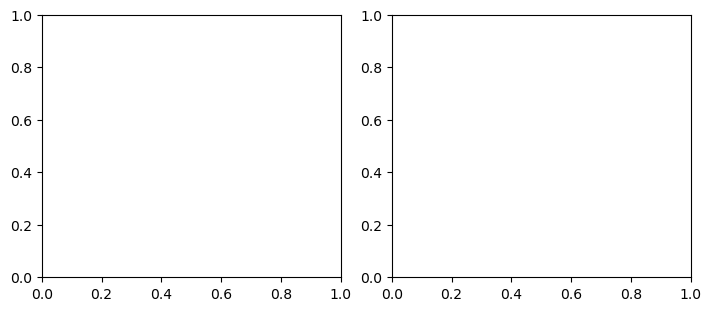

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Starting Training of GRU
Device: cuda
Epoch: 1


In [ ]:
model, samples = train(model, train_loader, test_loader, vectorizer, device)

In [ ]:
# save model
torch.save(model.state_dict(), './GRU_data/params/test1')